# a4 - Python

This assignment will cover topics of text mining and clustering

Make sure that you keep this notebook named as "a4.ipynb" 

Any other packages or tools, outside those listed in the assignments or Canvas, should be cleared
by Dr. Brown before use in your submission.

# Q0 - Setup

The following code looks to see whether your notebook is run on Gradescope (GS), Colab (COLAB), or the linux Python environment you were asked to setup.

In [2]:
import re 
import os
import platform 
import sys 

# flag if notebook is running on Gradescope 
if re.search(r'am', platform.uname().release): 
    GS = True
else: 
    GS = False

# flag if notebook is running on Colaboratory 
try:
  import google.colab
  COLAB = True
except:
  COLAB = False

# flag if running on Linux lab machines. 
cname = platform.uname().node
if re.search(r'(guardian|colossus|c28|coc-15954-m)', cname):
    LLM = True 
else: 
    LLM = False

print("System: GS - %s, COLAB - %s, LLM - %s" % (GS, COLAB, LLM))

System: GS - False, COLAB - False, LLM - True


## Notebook Setup

It is good practice to list all imports needed at the top of the notebook. You can import modules in later cells as needed, but listing them at the top clearly shows all which are needed to be available / installed.

If you are doing development on Colab, the otter-grader package is not available, so you will need to install it with pip (uncomment the cell directly below).

In [3]:
# Only uncomment if you developing on Colab 
# if COLAB == True: 
#     print("Installing otter:")
#     !pip install otter-grader==4.2.0 

In [4]:
# Import standard DS packages 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import statistics
import textwrap
%matplotlib inline


from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import tree        # decision tree classifier
from sklearn import neighbors   # knn classifier
from sklearn import naive_bayes # naive bayes classifier 
from sklearn import svm         # svm classifier
from sklearn import ensemble    # ensemble classifiers
from sklearn import metrics     # performance evaluation metrics
from sklearn import model_selection
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

# Package for Autograder 
import otter 
grader = otter.Notebook()

In [5]:
grader.check("q0")

q0 results: All test cases passed!

# Q1 - Text Classification 


You will look to predict whether scenes in Shakespeare's plays come from the comedies or histories.  Shakespeare's comedies include plays such as: The Taming of the Shrew, The Merchant of Venice, Much Ado About Nothing, and more.  The histories include: Richard II, Richard III, Henry IV part 1, Henry IV part 2, Henry V, Henry VI (part 1-3). 

The plays were downloaded from the [Shakespeare Corpus](http://hdl.handle.net/11040/24448).  Note, the original plays were downloaded from [Project Gutenberg](https://www.gutenberg.org/). 

Note, the plays have already had significant preprocessing.  The plays have been scrubbed by: removing digits, making the file all lowercase, and removing punctuation, excluding hyphens and word-internal apostrophes. Also, the character names and stage directions have been removed manually. An example of the text would be like this:

*Before scrubbing:*

    ADAM. Yonder comes my master, your brother.
    ORLANDO. Go apart, Adam, and thou shalt hear how he will shake me
    up. [ADAM retires]
    OLIVER. Now, sir! what make you here?

*After scrubbing:*

    yonder comes my master your brother
    go apart adam and thou shalt hear how he will shake me
    up
    now sir what make you here

The text files are split into negative - comedies and positive - histories.  


## Q1(a) - Load the Data 

Load the plays into a list `textdata` and a np.ndarray `yvalues`.  I highly suggest using `scikit-learn`'s `load_files` function, with the `random_state` set to 42.  

 

In [25]:
# Load the plays data     
plays = load_files("data/shakespeare", random_state=42)

# Extract text data
textdata = plays.data

# Extract target values
yvalues = plays.target

print("Samples per class: {}".format(np.bincount(yvalues)))

plays.filenames[0:10]

Samples per class: [119 208]


array(['data/shakespeare/histories/henryVIpartiiActIIIScenei_noCNnoSD.txt',
       'data/shakespeare/comedies/twelfthNightActIScenei_noCNnoSD.txt',
       'data/shakespeare/histories/henryVIpartiiActIVSceneviii_noCNnoSD.txt',
       'data/shakespeare/comedies/asYouLikeItActIIScenev_noCNnoSD.txt',
       'data/shakespeare/comedies/tempestActIIISceneii_noCNnoSD.txt',
       'data/shakespeare/histories/henryVIpartiActIVSceneii_noCNnoSD.txt',
       'data/shakespeare/histories/henryVIpartiiiActIVSceneviii_noCNnoSD.txt',
       'data/shakespeare/histories/henryVIIIActVScenei_noCNnoSD.txt',
       'data/shakespeare/histories/henryVIpartiActIIIScenei_noCNnoSD.txt',
       'data/shakespeare/comedies/twelfthNightActIIIScenei_noCNnoSD.txt'],
      dtype='<U72')

In [8]:
grader.check("q1a")

q1a results: All test cases passed!

## Q1(b) - Prepare the Data 

Split the data into `text_trainval`, `text_test` and `y_trainval`, `y_test` variables.  Use 20% of the data in the test set with a `random_state` of 42 and make sure to stratify the split (the data is imbalanced). 

In [26]:
# Split the data 
text_trainval, text_test, y_trainval, y_test = train_test_split(
    textdata, yvalues, test_size=0.2, random_state=42, stratify=yvalues)

print("Number of samples in training/validation set: {}".format(len(text_trainval)))
print("Number of samples in test set: {}".format(len(text_test)))

Number of samples in training/validation set: 261
Number of samples in test set: 66


In [10]:
grader.check("q1b")

q1b results: All test cases passed!

## Q1(c)  - Explore the Data

Create a document-term count matrix for the "trainval" data using the default tokenizer, removing the standard English stopwords and store this in `dtm_trainval`.

Store the names of the terms in the dtm matrix in the variable `vocab`.

In [27]:
# Create document-term count matrix for the "trainval" text data 
vectorizer = CountVectorizer(stop_words='english')

# Fit the vectorizer on the training/validation data and transform it to create the document-term matrix
dtm_trainval = vectorizer.fit_transform(text_trainval)

# Get the names of the terms (vocabulary)
vocab = vectorizer.get_feature_names_out()

print("Shape of document-term matrix (trainval):", dtm_trainval.shape)
print("Number of terms in vocabulary:", len(vocab))

Shape of document-term matrix (trainval): (261, 13953)
Number of terms in vocabulary: 13953


In [12]:
grader.check("q1c")

q1c results: All test cases passed!

<!-- BEGIN QUESTION -->

## Q1(d) - Explore the Data 

Create a plot showing the top 15 most frequently used words in the trainval text data. 

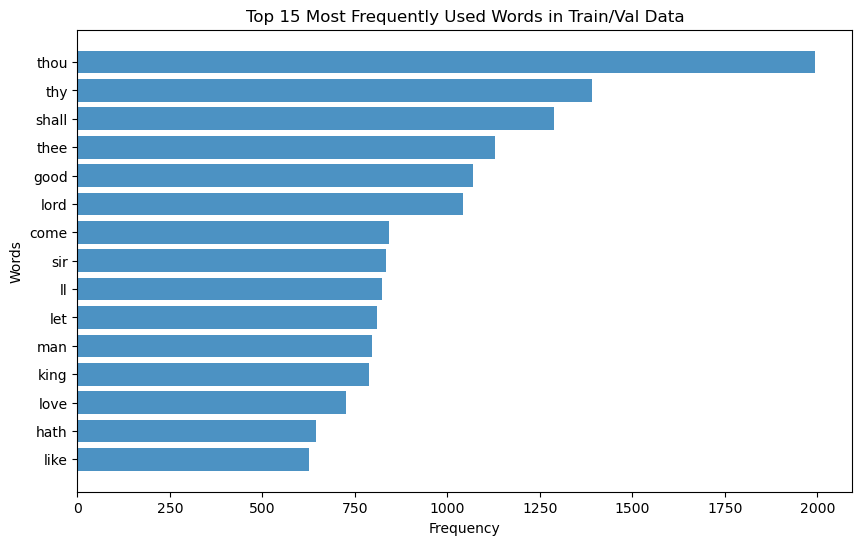

In [28]:
# Create a plot of the top 15 most frequently used words 

# Calculate the total count of each term across all documents
term_freq = np.asarray(dtm_trainval.sum(axis=0)).ravel()

# Create a dictionary with terms and their frequencies
term_freq_dict = dict(zip(vocab, term_freq))

# Sort the terms by frequency and get the top 15
top_terms = sorted(term_freq_dict.items(), key=lambda x: x[1], reverse=True)[:15]

# Extract terms and frequencies for plotting
top_terms, top_freq = zip(*top_terms)

# Plot the top 15 most frequently used words
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_terms)), top_freq, align='center', alpha=0.8)
plt.yticks(range(len(top_terms)), top_terms)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 15 Most Frequently Used Words in Train/Val Data')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent word on top
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Q1(e) - Explore the Data 

For the trainval text data, plot the top 15 most frequently used words in the histories and the comedies.  Put these two bar plots side-by-side to compare the results. 

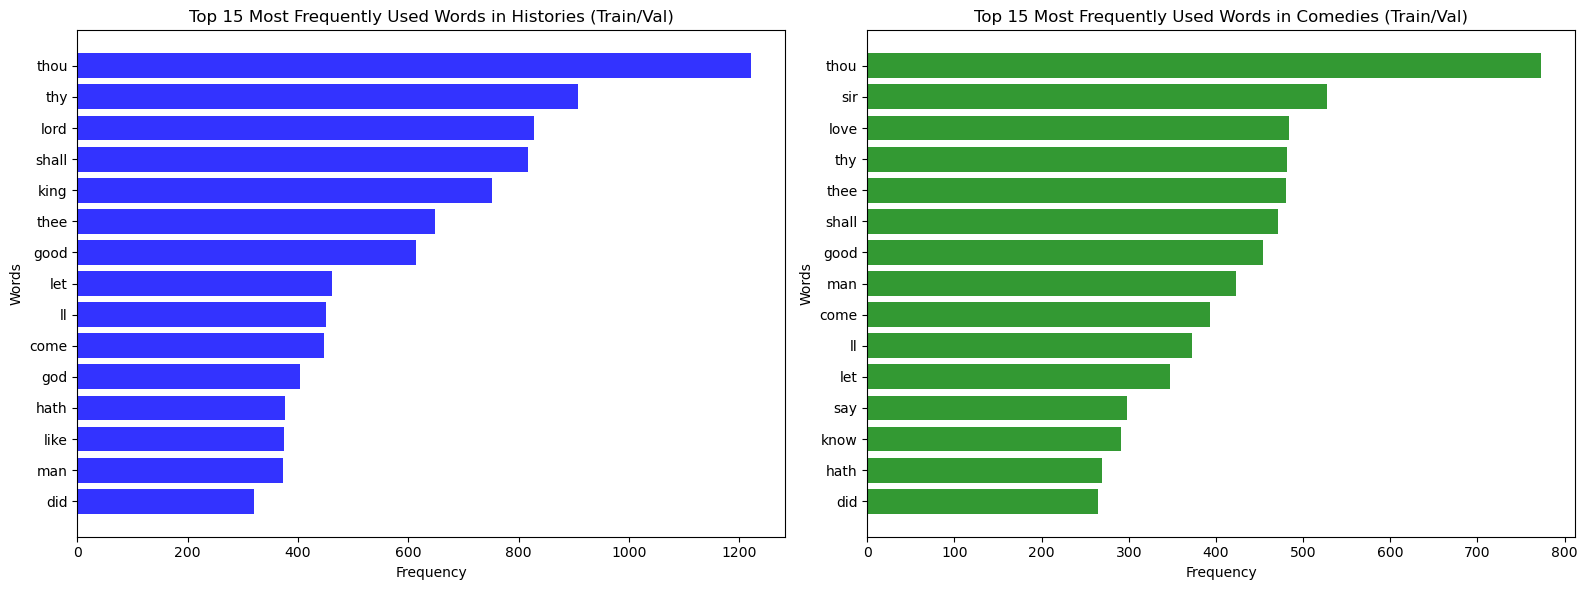

In [29]:
# Create a plot of the top 15 most frequently used words in the Comedies and Histories. 

# Find indices of documents corresponding to histories
histories_indices = np.where(y_trainval == 1)[0]
# Find indices of documents corresponding to comedies
comedies_indices = np.where(y_trainval == 0)[0]

# Extract text data for histories
histories_text = [text_trainval[i] for i in histories_indices]
# Extract text data for comedies
comedies_text = [text_trainval[i] for i in comedies_indices]

# Create document-term count matrix for histories
dtm_histories = vectorizer.transform(histories_text)
# Create document-term count matrix for comedies
dtm_comedies = vectorizer.transform(comedies_text)

# Calculate term frequencies for histories
term_freq_histories = np.asarray(dtm_histories.sum(axis=0)).ravel()
# Calculate term frequencies for comedies
term_freq_comedies = np.asarray(dtm_comedies.sum(axis=0)).ravel()

# Create a dictionary with terms and their frequencies for histories
term_freq_histories_dict = dict(zip(vocab, term_freq_histories))
# Create a dictionary with terms and their frequencies for comedies
term_freq_comedies_dict = dict(zip(vocab, term_freq_comedies))

# Sort the terms by frequency and get the top 15 for histories
top_terms_histories = sorted(term_freq_histories_dict.items(), key=lambda x: x[1], reverse=True)[:15]
# Sort the terms by frequency and get the top 15 for comedies
top_terms_comedies = sorted(term_freq_comedies_dict.items(), key=lambda x: x[1], reverse=True)[:15]

# Extract terms and frequencies for plotting for histories
top_terms_histories, top_freq_histories = zip(*top_terms_histories)
# Extract terms and frequencies for plotting for comedies
top_terms_comedies, top_freq_comedies = zip(*top_terms_comedies)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the top 15 most frequently used words for histories
axs[0].barh(range(len(top_terms_histories)), top_freq_histories, align='center', alpha=0.8, color='blue')
axs[0].set_yticks(range(len(top_terms_histories)))
axs[0].set_yticklabels(top_terms_histories)
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Words')
axs[0].set_title('Top 15 Most Frequently Used Words in Histories (Train/Val)')
axs[0].invert_yaxis()  # Invert y-axis to have the most frequent word on top

# Plot the top 15 most frequently used words for comedies
axs[1].barh(range(len(top_terms_comedies)), top_freq_comedies, align='center', alpha=0.8, color='green')
axs[1].set_yticks(range(len(top_terms_comedies)))
axs[1].set_yticklabels(top_terms_comedies)
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Words')
axs[1].set_title('Top 15 Most Frequently Used Words in Comedies (Train/Val)')
axs[1].invert_yaxis()  # Invert y-axis to have the most frequent word on top

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

<!-- END QUESTION -->

## Q1(f) - Bernoulli Naive Bayes 

Let's know explore using Bernoulli Naive Bayes as a classifier, `bern_nb`, to predict the type of play. 

We will use the split of the data into trainval / test found above to train the model and then evaluate it's performance. 

Create the training data, `X_trainval` to be binary with features using the default tokenizer, stop words removed, appear in at least 5 documents and is limited to the top 5000 features.  

Calculate the training accuracy `train_acc_bern` and testing accuracy `test_acc_bern` for the model.



In [30]:
# Run Bernoulli Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

# Create a TfidfVectorizer with binary=True explicitly
vectorizer = TfidfVectorizer(binary=True, stop_words='english', min_df=5, max_features=5000)

# Fit and transform the vectorizer on the trainval data
X_trainval = vectorizer.fit_transform(text_trainval)

# Threshold the feature matrix to ensure binary features
X_trainval[X_trainval > 0] = 1

# Create a Bernoulli Naive Bayes classifier
bern_nb = BernoulliNB()

# Train the classifier on the training data
bern_nb.fit(X_trainval, y_trainval)

# Calculate training accuracy
train_acc_bern = bern_nb.score(X_trainval, y_trainval)

# Transform the test data using the same vectorizer
X_test = vectorizer.transform(text_test)

# Calculate testing accuracy
test_acc_bern = bern_nb.score(X_test, y_test)

print("Training Accuracy (Bernoulli NB):", train_acc_bern)
print("Testing Accuracy (Bernoulli NB):", test_acc_bern)

Training Accuracy (Bernoulli NB): 0.9501915708812261
Testing Accuracy (Bernoulli NB): 0.8636363636363636


In [31]:
grader.check("q1f")

q1f results: All test cases passed!

## Q1(g) - Multinomial Naive Bayes 

Let's know explore using multinomial Naive Bayes as a classifier, `mult_nb`, to predict the type of play. 

We will use the split of the data into trainval / test found above to train the model and then evaluate it's performance. 

Create the training data, `X_trainval` with features using the default tokenizer, stop words removed, appear in at least 5 documents and is limited to the top 5000 features.  

Calculate the training accuracy `train_acc_mult` and testing accuracy `test_acc_mult` for the model.


In [39]:
# Run Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mult_nb = MultinomialNB()

vectorizer = TfidfVectorizer(binary=True, stop_words='english', min_df=5, max_features=5000)

X_trainval = vectorizer.fit_transform(text_trainval)

# Threshold the feature matrix to ensure binary features
X_trainval[X_trainval > 0] = 1

# Train the classifier on the training data
mult_nb.fit(X_trainval, y_trainval)

# Calculate training accuracy
train_acc_mult = mult_nb.score(X_trainval, y_trainval)

# Transform the test data using the same vectorizer
X_test = vectorizer.transform(text_test)

# Calculate testing accuracy
test_acc_mult = mult_nb.score(X_test, y_test)

print("Training Accuracy (Multinomial Naive Bayes):", train_acc_mult)
print("Testing Accuracy (Multinomial Naive Bayes):", test_acc_mult)

Training Accuracy (Multinomial Naive Bayes): 1.0
Testing Accuracy (Multinomial Naive Bayes): 0.9393939393939394


In [40]:
grader.check("q1g")

q1g results:
    q1g - 1 result:
        ✅ Test case passed

    q1g - 2 result:
        ✅ Test case passed

    q1g - 3 result:
        ❌ Test case failed
        Trying:
            all(X_trainval[5, 1280:1290].toarray()[0] == [0, 2, 0, 0, 0, 0, 0, 0, 0, 1])
        Expecting:
            True
        **********************************************************************
        Line 1, in q1g 2
        Failed example:
            all(X_trainval[5, 1280:1290].toarray()[0] == [0, 2, 0, 0, 0, 0, 0, 0, 0, 1])
        Expected:
            True
        Got:
            False

<!-- BEGIN QUESTION -->

## Q1(h) - Naive Bayes Models 

Looking at the results of the two models above. Answer the following questions.  


Which of the two models is preferred?  Why?   (10 words or less)
    Multinomial, it is more accurate.

What is a problem for both models?  How might you solve it? (12 words or less)
    Both have less accuracy in testing than training. Change testing parameters.

<!-- END QUESTION -->

## Q1(i) - Other Models 

Let's now look to explore using other models. 

You will set up a pipeline, `pipe`, that will use a Random Forest model with 100 trees and a `random_state` = 42.  

In the pipeline (`param_grid`), you will consider using both a document term count matrix as well as a TF-IDF matrix. 
In either case, limit the matrix to words that appear in at least 5 documents and remove English stop words.  Consider features of unigrams, unigrams + bigrams, and bigrams.  Examine a maximum feature limit of either 2500 or 5000.  

Optimize your choice of hyperparameters using GridSearchCV, `grid`, with stratified 5-fold cross-validation (random_state = 42), select the parameters using AUC. (See how to set up the scorer below)

Note, do not run the jobs in parallel, you may exceed the memory resources of the autograder on Gradescope. 

In [41]:
# Run Pipeline to find best model
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('vec', CountVectorizer()),  # Placeholder for vectorizer (will be replaced in param_grid)
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))  # Random Forest classifier
])

# Define the parameter grid
param_grid = [
    {
        'vec': [CountVectorizer(), TfidfVectorizer()],
        'vec__binary': [False],  # Using term frequency (TF) instead of binary features
        'vec__max_features': [2500, 5000],
        'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'vec__min_df': [5],
        'vec__stop_words': ['english'],
    }
]

# Define the stratified 5-fold cross-validation
cvStrat = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Define the scorer using AUC
score_fn = metrics.make_scorer(metrics.roc_auc_score, needs_threshold=False)

# Run GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=cvStrat, scoring=score_fn, n_jobs=1)  # Disable parallel jobs

# Fit the grid search object to find the best model
grid.fit(text_trainval, y_trainval)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.89
Best parameters:
{'vec': TfidfVectorizer(max_features=2500, min_df=5, stop_words='english'), 'vec__binary': False, 'vec__max_features': 2500, 'vec__min_df': 5, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}


In [42]:
grader.check("q1i")

q1i results: All test cases passed!

## Q1(j) - Explore the Results 

Calculate the AUC on the test text, `auc_test`.   

Gather the importances of the features in the best model in `importance`. [Feature Importance Example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Create a bar plot with the top 10 features sorted by importance.  


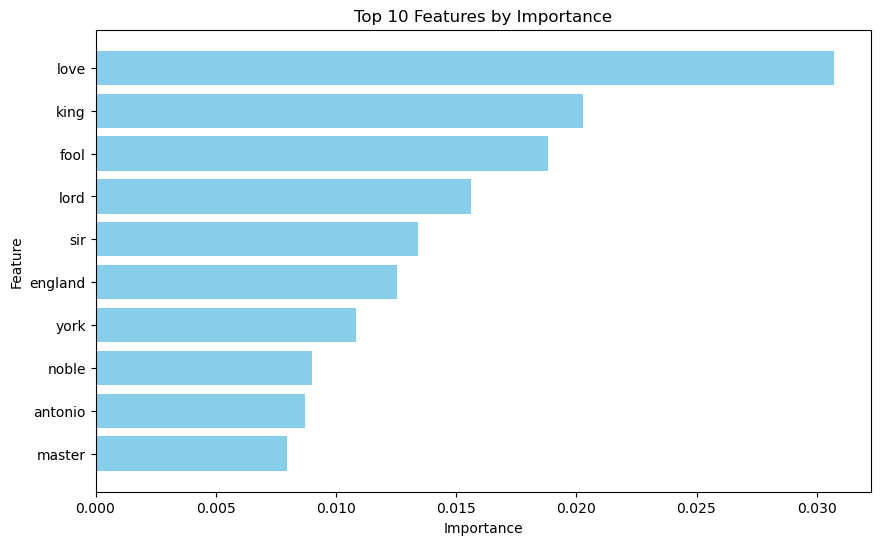

(0.9955357142857143,
 array([0.        , 0.        , 0.00054952, ..., 0.00224121, 0.0001259 ,
        0.        ]))

In [43]:
# Calculate performance on test data `auc_test` 
from sklearn.metrics import roc_auc_score

# Extract the best model from the grid search
best_model = grid.best_estimator_
# Predict probabilities on the test set
y_test_prob = best_model.predict_proba(text_test)[:, 1]
# Calculate AUC on the test set
auc_test = roc_auc_score(y_test, y_test_prob)
# Extract feature importances
importance = best_model.named_steps['clf'].feature_importances_
# Get the feature names from the vectorizer
feature_names = best_model.named_steps['vec'].get_feature_names_out()

# Create a dictionary of feature names and their corresponding importances
feature_importance_dict = dict(zip(feature_names, importance))

# Sort the features by importance in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the top 10 features
top_features = sorted_features[:10]

# Plot the top 10 features by importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in top_features], [f[1] for f in top_features], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features by Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

auc_test, importance


In [44]:
grader.check("q1j")

q1j results: All test cases passed!

# Q2

Consider methods to cluster NBA players based on their statistics. 




## Q2(a) 

Load in data for NBA players from the 2018-2019 season. 

Filter the players to only consider those who have played in more than 20 games.  

Ignore the first 7 columns as well as ignore columns of statistics with percentages (FG%, 3P%, 2P%, eFG%, FT%). 

In [45]:
# Load in data and filter out requested rows and columns
nba = pd.read_csv("data/nba18-19.csv")

# Filter players who have played in more than 20 games
nba = nba[nba['G'] > 20]

# Ignore the first 7 columns and columns with percentages
columns_to_ignore = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
nba = nba.drop(columns=columns_to_ignore)

nba.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.4,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.3,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,3.7,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,...,2.8,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9
7,8,LaMarcus Aldridge\aldrila01,C,33,SAS,81,81,33.2,8.4,16.3,...,5.1,3.1,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3


In [46]:
grader.check("q2a")

q2a results: All test cases passed!

## Q2(b)

The features have different ranges, therefore we should scale the data before considering the clustering analysis. Scale the data using min-max normalization with range of [0, 1].

In [47]:
# Create a new DataFrame excluding the first 7 columns
nba_new = nba.iloc[:, 7:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
nbaScaled = scaler.fit_transform(nba_new)

In [48]:
grader.check("q2b")

q2b results: All test cases passed!

## Q2(c)

Run Kmeans clustering on the data with k=2, . . . , 12.  Set the `random_state` in the Kmeans method to 42 and `n_init` to 10. 
For each value of k, keep track of the within-cluster variation (this quantity is referred to as different terms such as “inertia” and total “within-cluster sum-of-squares”), the Calinski-Harabasz score, and the Davies-Bouldin index on the resulting clusters. 

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Initialize lists to store metrics for each value of k
sse = []  # Sum of Squared Errors (inertia)
dbscore = []  # Davies-Bouldin score
chscore = []  # Calinski-Harabasz score

# Define range of k values
k_values = range(3, 12)

# Loop through each value of k
for k in k_values:
    # Initialize KMeans clustering with specified parameters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Fit KMeans to the scaled data
    kmeans.fit(nbaScaled)
    
    # Calculate Sum of Squared Errors (inertia)
    sse.append(kmeans.inertia_)
    
    # Calculate Davies-Bouldin index
    db_index = davies_bouldin_score(nbaScaled, kmeans.labels_)
    dbscore.append(db_index)
    
    # Calculate Calinski-Harabasz score
    ch_index = calinski_harabasz_score(nbaScaled, kmeans.labels_)
    chscore.append(ch_index)

# Print the length of sse
print("Length of SSE:", len(sse))

# Print the metrics for each value of k
for k, sse_val, db_val, ch_val in zip(k_values, sse, dbscore, chscore):
    print(f"K = {k}: Sum of Squared Errors = {sse_val}, Davies-Bouldin Score = {db_val}, Calinski-Harabasz Score = {ch_val}")


Length of SSE: 9
K = 3: Sum of Squared Errors = 106.41949558782024, Davies-Bouldin Score = 1.3096063140033045, Calinski-Harabasz Score = 260.0592921397654
K = 4: Sum of Squared Errors = 91.29571602491272, Davies-Bouldin Score = 1.257964894892034, Calinski-Harabasz Score = 224.5797748678714
K = 5: Sum of Squared Errors = 80.77723841699175, Davies-Bouldin Score = 1.3187069937467255, Calinski-Harabasz Score = 203.4199984438504
K = 6: Sum of Squared Errors = 73.90408342870403, Davies-Bouldin Score = 1.2951155937122232, Calinski-Harabasz Score = 185.14249269349628
K = 7: Sum of Squared Errors = 68.01218188791024, Davies-Bouldin Score = 1.3856480723021458, Calinski-Harabasz Score = 173.20925326424177
K = 8: Sum of Squared Errors = 63.852890733446884, Davies-Bouldin Score = 1.3417042100077925, Calinski-Harabasz Score = 161.58686812133163
K = 9: Sum of Squared Errors = 60.66617423376536, Davies-Bouldin Score = 1.3850651379832768, Calinski-Harabasz Score = 151.15292750165608
K = 10: Sum of Squa

In [50]:
grader.check("q2c")

q2c results: All test cases passed!

## Q2(d)

Assuming the best number of clusters is 4 (depending on which measure we use different number of clusters is preferred with this data). 

Run Kmeans again with this value for $k$ (use `n_init` = 10 and `random_state` = 10).

Create a DataFrame `clusterStats` with the mean statistics (centers) of each group. 

The DataFrame should have rows for each cluster group 0, 1, 2, 3 and columns for the mean statistics.  

Add a column `Num` reporting the number of samples in each group. 


In [51]:
# Create a Data Frame for the mean statistics of each group 
# Assuming the best number of clusters is 4
best_k = 4

# Initialize KMeans model with best value of k
kmeans_best = KMeans(n_clusters=best_k, random_state=10, n_init=10)

# Fit the model to the scaled data
kmeans_best.fit(nbaScaled)

# Get the cluster centers (mean statistics)
cluster_centers = scaler.inverse_transform(kmeans_best.cluster_centers_)

# Create DataFrame for cluster statistics
clusterStats = pd.DataFrame(cluster_centers, columns=nba_new.columns)

# Add column for number of samples in each group
clusterStats['Num'] = pd.Series(kmeans_best.labels_).value_counts().sort_index().values

clusterStats[['Num', 'MP', 'FG', '3P', 'FT']]
clusterStats


,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Num
0,15.048756,2.015920,4.552239,0.600995,1.787065,1.412935,2.766667,0.753731,1.038308,0.657711,2.024876,2.679602,1.227363,0.437811,0.314925,0.695522,1.504975,5.383085,201
1,33.391304,7.991304,17.121739,2.026087,5.621739,5.960870,11.495652,4.339130,5.408696,1.197826,5.334783,6.536957,5.258696,1.191304,0.613043,2.721739,2.360870,22.341304,46
2,27.018400,4.183200,9.619200,1.512000,4.181600,2.673600,5.438400,1.624800,2.065600,0.712000,3.157600,3.865600,2.816800,0.889600,0.390400,1.410400,2.141600,11.498400,125
3,26.404167,5.147917,9.587500,0.477083,1.404167,4.683333,8.181250,2.250000,3.179167,2.470833,5.833333,8.310417,1.956250,0.777083,1.050000,1.556250,2.725000,13.035417,48


In [52]:
grader.check("q2d")

q2d results: All test cases passed!

## Q2(e)

Report the same statistics as in (e), but using the original data scaling (reverse the scaling back to the original data range). 

Store results in `clusterStatsOrig`; this DataFrame should not have the "Num" column.



In [53]:
# Create a Data Frame for the mean statistics of each group (using the original data scaling)

# Apply inverse transformation to get original data range
cluster_centers_orig = scaler.inverse_transform(cluster_centers)

# Create DataFrame for cluster statistics with original data scaling
clusterStatsOrig = pd.DataFrame(cluster_centers_orig, columns=nba_new.columns)

# Reorder columns
clusterStatsOrig = clusterStatsOrig[list(nba_new.columns)]

clusterStatsOrig[['MP', 'FG', '3P', 'FT']]


,MP,FG,3P,FT
0,501.913831,21.568756,3.065075,7.311194
1,1109.052174,84.907826,10.333043,42.089565
2,898.109040,44.541920,7.711200,15.760560
3,877.777917,54.767917,2.433125,21.825000


In [54]:
grader.check("q2e")

q2e results: All test cases passed!

<!-- BEGIN QUESTION -->

## Q2(f) 

Apply PCA to the basketball data.  Plot the first two principal components, colored by the best group labels found above.  

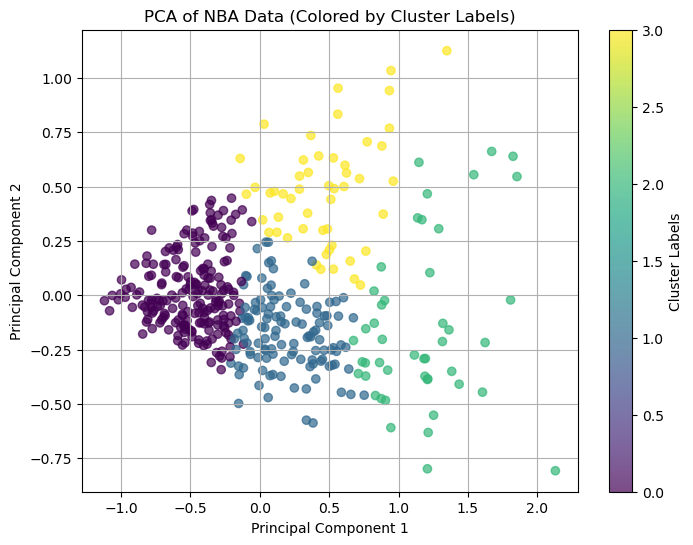

In [55]:
# Run PCA on the nba data and plot the first two principal components
#  colored by the group labels. 

# Run KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(nbaScaled)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Fit PCA to the scaled basketball data
pca = PCA(n_components=2)
pca.fit(nbaScaled)

# Transform the data into the principal component space
nba_pca = pca.transform(nbaScaled)

# Plot the first two principal components colored by the cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(nba_pca[:, 0], nba_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('PCA of NBA Data (Colored by Cluster Labels)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Labels')
plt.grid(True)
plt.show()


<!-- END QUESTION -->

# Q3 : Clustering - Spotify Music

For this problem you will look at popular streaming music.  Specifically, Spotify's top 100 streaming songs.  For each song information about the song is described with different properties: `duration`, `energy`, `key`, etc. 


## Q3(a) - Load and Prepare the Data 

Load in the `music.csv` data.  

The clustering algorithms will only consider variables of `duration` to the end of the DataFrame. 

Standardize the variables to be used in clustering.  

In [87]:
# Load in music data 

music = pd.read_csv('data/music.csv')

selected_columns = music.iloc[:, 5:]

scaler = StandardScaler()
standardized_columns = scaler.fit_transform(selected_columns)

music.iloc[:, 5:] = standardized_columns

music.head()

,Song,Artist,Streams (Billions),Release Date,id,duration,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability
0,Blinding Lights,The Weeknd,3.449,29-Nov-19,0VjIjW4GlUZAMYd2vXMi3b,-0.379751,0.656231,-1.202571,0.121245,0.733799,-0.414447,-0.956146,-0.159096,-0.621522,-0.750727,1.692429,-0.942577
1,Shape of You,Ed Sheeran,3.398,06-Jan-17,7qiZfU4dY1lWllzX7mPBI3,0.329251,0.166413,-1.202571,1.497770,-1.362770,-0.183746,1.179255,-0.161053,-0.593711,1.916528,-0.859868,1.218755
2,Dance Monkey,Tones And I,2.770,10-May-19,2XU0oxnq2qxCpomAAuJY8K,-0.180733,-0.235490,0.182880,-0.111928,-1.362770,-0.045778,1.588251,-0.158919,-0.136456,0.049002,-0.790131,1.211806
3,Someone You Loved,Lewis Capaldi,2.680,08-Nov-18,7qEHsqek33rTcFNT9PFqLf,-0.740472,-1.384680,-1.202571,0.248840,0.733799,-0.729964,1.805645,-0.161053,-0.496370,-0.250338,-0.386542,-1.032922
4,Rockstar,Post Malone featuring 21 Savage,2.620,15-Sep-17,0e7ipj03S05BNilyu5bRzt,0.005846,-0.662511,-0.094211,0.020170,-1.362770,-0.285526,-0.504629,-0.159615,-0.283694,-1.666619,1.311292,-0.449154


In [88]:
grader.check("q3a")

q3a results: All test cases passed!

## Q3(b) - Hierarchical Clustering 

Perform Hierarchical clustering with **single** linkage on just the top 30 songs. 

Report results in a dendrogram, `dg_single` and label the samples by the Artist.  



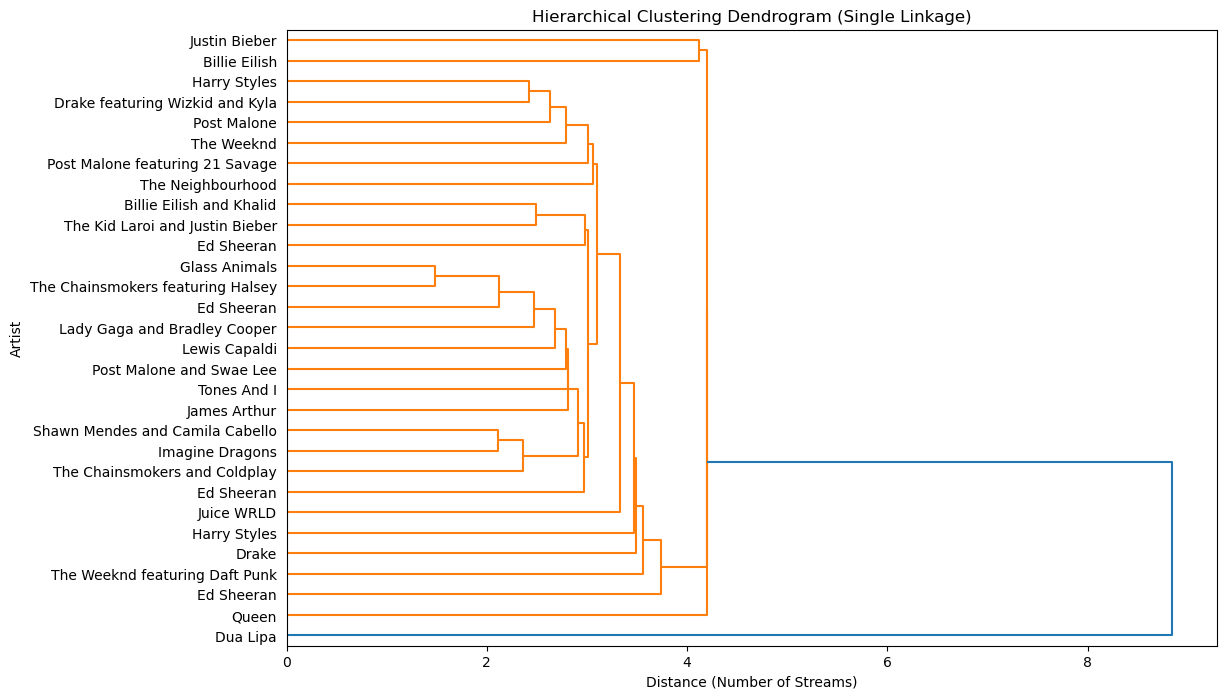

In [94]:
# Perform Hierarchical clustering with single linkage on top 30 songs 
# Report results in a dendrogram, dg_single

import scipy.cluster.hierarchy as sch

# Find the top 30 songs based on the number of streams
top_30_songs_data = music.nlargest(30, 'Streams (Billions)')  

# Extract artist names for labeling
artists = top_30_songs_data['Artist'].tolist()

data_for_clustering = top_30_songs_data.iloc[:, 5:].values

# Perform hierarchical clustering using single linkage
linkage_matrix = sch.linkage(data_for_clustering, method='single')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dg_single = sch.dendrogram(linkage_matrix, labels=artists, orientation='right')

plt.title('Hierarchical Clustering Dendrogram (Single Linkage)')
plt.xlabel('Distance (Number of Streams)')
plt.ylabel('Artist')

plt.show()

In [95]:
grader.check("q3b")

q3b results: All test cases passed!

## Q3(c) - Hierarchical Clustering, part 2 

Perform Hierarchical clustering with **complete** linkage on just the top 30 songs.

Report results in a dendrogram, `dn_complete` and label the samples by the Artist.

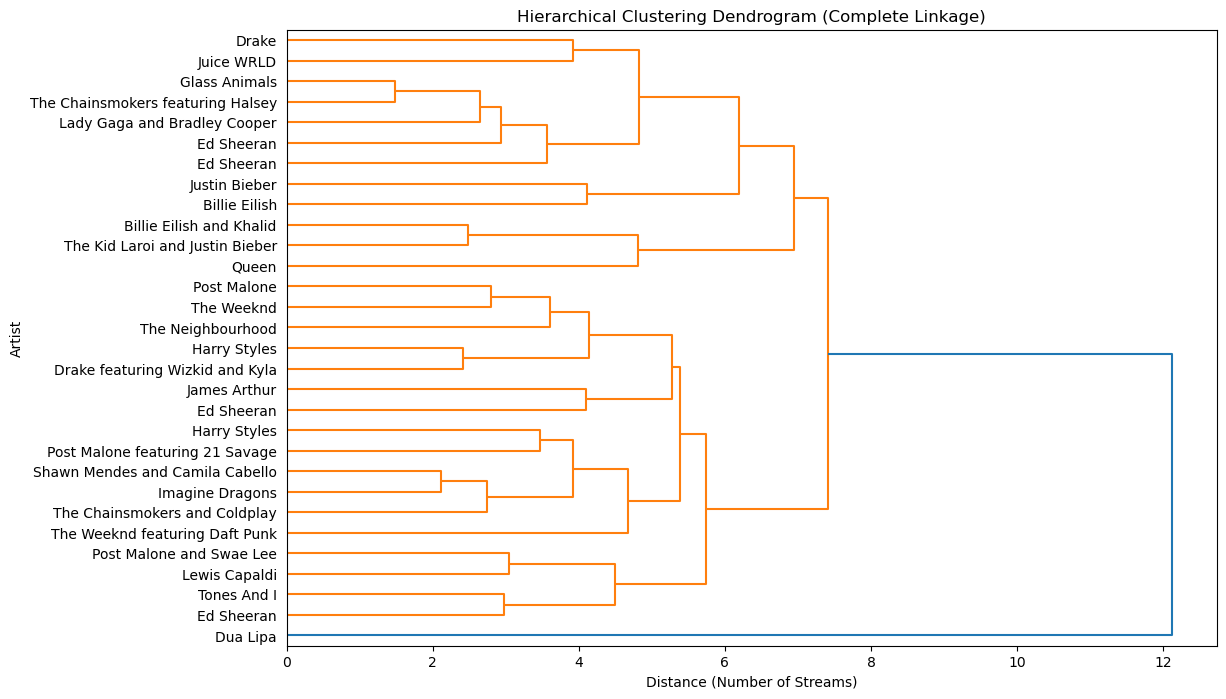

In [96]:
# Perform Hierarchical clustering with complete linkage on top 30 songs 
# Report results in a dendrogram, dg_complete

# Find the top 30 songs based on the number of streams
top_30_songs_data = music.nlargest(30, 'Streams (Billions)')  # Adjust column name as per your dataset

# Extract artist names for labeling
artists = top_30_songs_data['Artist'].tolist()

# Perform hierarchical clustering
# Use the number of streams directly as the features
# No need for distance calculation, as the number of streams itself serves as the distance
# You'll only need to reshape the data to fit the expected format for hierarchical clustering
data_for_clustering = top_30_songs_data.iloc[:, 5:].values

# Perform hierarchical/agglomerative clustering using complete linkage
linkage_matrix = sch.linkage(data_for_clustering, method='complete')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dg_complete = sch.dendrogram(linkage_matrix, labels=artists, orientation='right')

plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Distance (Number of Streams)')
plt.ylabel('Artist')
plt.show()


In [97]:
grader.check("q3c")

q3c results: All test cases passed!

## Q3(d) - Hierarchical Clustering, part 3

Perform Hierarchical clustering with **aveage** linkage on just the top 30 songs.

Report results in a dendrogram, `dn_average` and label the samples by the Artist.

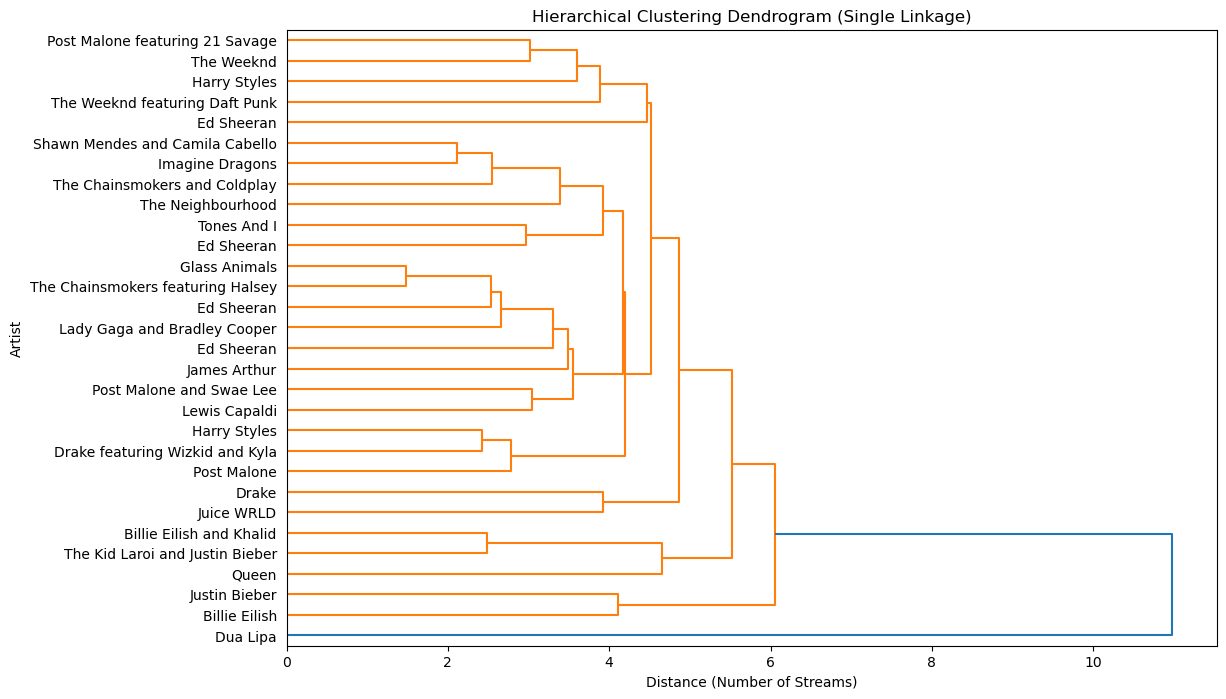

In [98]:
# Perform Hierarchical clustering with average linkage on top 30 songs 
# Report results in a dendrogram, dg_average

import scipy.cluster.hierarchy as sch

# Find the top 30 songs based on the number of streams
top_30_songs_data = music.nlargest(30, 'Streams (Billions)')  

# Extract artist names for labeling
artists = top_30_songs_data['Artist'].tolist()

data_for_clustering = top_30_songs_data.iloc[:, 5:].values

# Perform hierarchical clustering using single linkage
linkage_matrix = sch.linkage(data_for_clustering, method='average')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dg_average = sch.dendrogram(linkage_matrix, labels=artists, orientation='right')

plt.title('Hierarchical Clustering Dendrogram (Single Linkage)')
plt.xlabel('Distance (Number of Streams)')
plt.ylabel('Artist')

plt.show()

In [99]:
grader.check("q3d")

q3d results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

**NOTE** the submission must be run on the campus linux machines.  See the instruction in the Canvas assignment.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)